## Assignment notebook 10.7

Your assignment is to apply a probabilistic model similar to the switchpoint model in notebook 10.6. You can either follow the instructions below to generate a model like in notebook 10.6, or if you are feeling ambitious, you can choose another example model implementation from the [examples section](http://docs.pymc.io/examples.html) of the pymc3 documentation. 

You task is to use `np.random` to generate data under a known distribution and then to apply probabilistic inference using pymc3 to fit a model for the parameters of your generative model. See notebooks 10.4 or 10.6 for good examples. 

# Predictive Model for SIPA Graduation Date Based on Dragon Sighting Rates

It is rumored that graduate students report a marked increase in dragon sightings following their graduation. In this exercise, I simulate data and build a model to predict the switchpoint (aka SIPA graduation day) for increased dragon sighting rates.

In [1]:
# suppress warning messages from pymc3
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd
import toyplot
import pymc3 as pm

## Generate data

_Instructions: Generate data into a dataframe called `data` using numpy and pandas. Your data must be different from what was used in the examples already. Choose different parameters. The intention here is that you will test how changing parameters changes the results. Play around with trying out several different values._

Generate data for dragon sightings per day for graduating SIPA students, with an increase in sightings from 1.5/day to 6/day following SIPA graduation on May 13 (day 133).

I referred to the class notebook [nb-10.6-pymc3-switchpoint.ipynb](http://localhost:8888/notebooks/nb-10.6-pymc3-switchpoint.ipynb) for how to use a switchpoint model, which was also based on the pymc3 tutorial [case study 2](https://docs.pymc.io/notebooks/getting_started.html#Case-study-2:-Coal-mining-disasters), and reviewed [this Analytics Vidhya page](https://www.analyticsvidhya.com/blog/2016/06/bayesian-statistics-beginners-simple-english/) for a brief overview of Bayesian statistics.

In [3]:
# fix a random seed
np.random.seed(5432)

# generate data for the days of the year, with higher rates after day 133
data = pd.DataFrame({
    "day": np.arange(1, 365),
    "dragon_sightings": np.concatenate([
        np.random.poisson(1.5, 133),
        np.random.poisson(6.0, 231),
    ])
})

# introduce some random NaN values (pymc3 will handle these)
missing = np.random.randint(0, data.shape[0], 5)
data.loc[missing, "dragon_sightings"] = np.nan

In [4]:
data.head()

,day,dragon_sightings
0,1,1.0
1,2,3.0
2,3,5.0
3,4,1.0
4,5,2.0


## Plot data

In [5]:
# plot the generated data
toyplot.scatterplot(
    data.day,
    data.dragon_sightings,
    color="orange",
    width=600, 
    height=300,
    size=5, 
    opacity=0.7,
    xlabel="Day of the year", 
    ylabel="Number of dragon sightings",
);

0 100 200 300 400 Day of the year 0 4 8 12 Number of dragon sightings

## Build and fit model

In [6]:
with pm.Model() as dragon_model:

    # sample switchpoint (graduation day) from within the bounds of our days of the year
    switchpoint = pm.DiscreteUniform(
        'switchpoint',
        lower=data.day.min(), 
        upper=data.day.max(), 
        testval=110)

    # Priors for pre-graduation and post-graduation rates for number of dragon sightings
    student_rate = pm.Exponential('student_rate', 1.)
    alum_rate = pm.Exponential('alum_rate', 1.)

    # Allocate appropriate Poisson rates to days before and after current
    rate = pm.math.switch(switchpoint >= data.day, student_rate, alum_rate)

    dragon_sightings = pm.Poisson('dragon_sightings', rate, observed=data.dragon_sightings)

In [7]:
with dragon_model:
    trace = pm.sample(15000)

Assigned Metropolis to switchpoint
Assigned NUTS to student_rate_log__
Assigned NUTS to alum_rate_log__
Assigned Metropolis to dragon_sightings_missing
100%|█████████▉| 15497/15500 [04:53<00:00, 52.78it/s]C:\Users\ILANA\Miniconda3\lib\site-packages\pymc3\step_methods\hmc\nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.8807830214728862, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 15500/15500 [04:53<00:00, 52.78it/s]


## Plot the trace

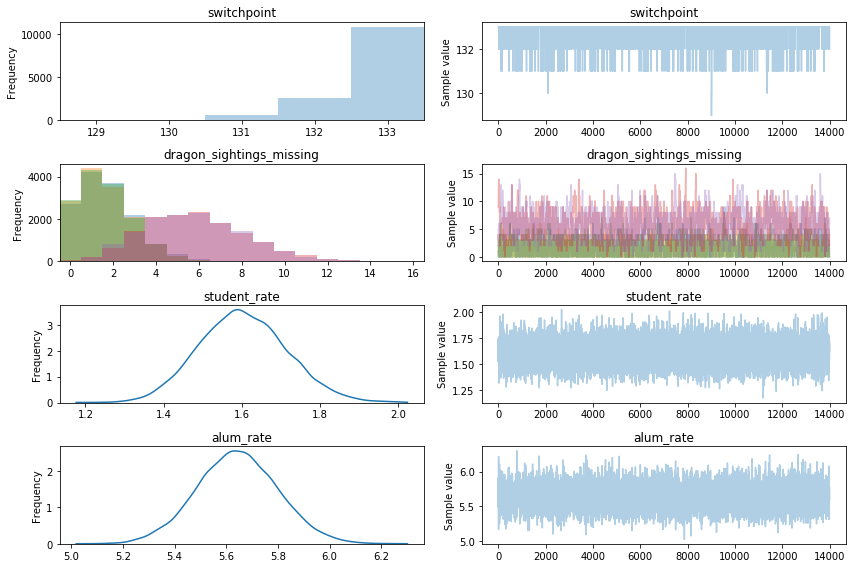

In [8]:
pm.traceplot(trace[1000:]);

## Summary statistics

In [9]:
pm.summary(trace)


switchpoint:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  132.732          0.538            0.012            [132.000, 133.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  131.000        133.000        133.000        133.000        133.000


dragon_sightings_missing:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.693            1.329            0.045            [0.000, 4.000]
  1.616            1.273            0.043            [0.000, 4.000]
  1.611            1.264            0.037            [0.000, 4.000]
  5.806            2.381            0.119            [1.000, 10.000]
  5.761            2.360            0.108            [2.000, 10.000]

  Posterior quantiles:
  2.

## Discussion

**Describe how closely your model predicted your generative parameters.**

The model was very good at predicting the generative parameters, predicting very closely the switchpoint day, and the differing rates of dragon sightings by SIPA students before graduation and SIPA students (alumni) after graduation on day 133 of the year.

**Are your parameters within the 95% HPD interval?**

With 15,000 samples, two out of three parameters are within the 95% HPD interval. The switchpoint parameter was day 133, and the 95% HPD interval was 132.00-133.00. The prior student (before graduation/switchpoint) rate of sightings was 1.5/day, and the 95% HPD interval was 1.396-1.827. However, the prior alum (after graduation/switchpoint) rate of sightings was 6/day which is just above the 95% HPD interval of 5.333-5.944. When I reran the model with 20,000 samples, the same two of three parameters were within the 95% HPD interval, but the third HPD interval remained the same.

**Do you think you ran the MCMC sampler long enough?**

I ran the sampler for 15,000 iterations at first and then reran for 20,000, and observed an increase in model fit in the second case. Running for 10,000 iterations still produced a very close fit.

**Do you think anything went wrong? If so, what did you try to troubleshoot the problem?**

At first, I was not sure why running the MCMC sampler longer did not improve the the 95% HPD interval for the alum rate of dragon sightings. I tried adjusting the upper limit for missing values from 5 (below the alum sighting rate of 6/day) to other higher integer values - thinking that having lower values inputted for the missing values might skew the values downward - but this did not have the effect I was seeking. I am unclear how to improve the fit for the alum rate.

**Did you seek help or answers?**

I referred to the class notebook [nb-10.6-pymc3-switchpoint.ipynb](http://localhost:8888/notebooks/nb-10.6-pymc3-switchpoint.ipynb) for how to use a switchpoint model, which was also based on the pymc3 tutorial [case study 2](https://docs.pymc.io/notebooks/getting_started.html#Case-study-2:-Coal-mining-disasters), reviewed [this Analytics Vidhya page](https://www.analyticsvidhya.com/blog/2016/06/bayesian-statistics-beginners-simple-english/) for a brief overview of Bayesian statistics, and referenced the [Toyplot plotting documentation](http://toyplot.readthedocs.io/en/stable/tutorial.html#plotting).